# Деревья решений

На этом семинаре попробуем сами написать дерево решений для решения задачи классификации на популярном датасете Iris

In [111]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_iris

In [112]:
iris_dataset = load_iris()

df = pd.DataFrame(data=iris_dataset.data, columns=iris_dataset.feature_names)
df['target'] = iris_dataset.target
df['target'] = df.target.apply(lambda v: iris_dataset.target_names[v])

print(len(df))

150


In [113]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## **Сделай сам**: решающий пень

Самый простой вариант дерева решений - так называемый *решающий пень* (decision stump). Отличие решающего пня от решающего дерева заключается в том, что пень всегда состоит только из одной вершины, то есть для его реализации нам не придется заморачиваться с рекурсивным перебором

Начнем с того, что научимся считать прирост энтропии после разбиения множества на две части.

In [114]:
from math import log2


"""
Пошаговый разбор:

Шаг 1:
y: pd.Series -> изначальная выборка с целевыми переменными
0     2
1     2
2     1
3     1
4     2
5     3
Name: target, dtype: int64

Шаг 2:
probas = y.value_counts(normalize=True) -> Отображение класса на долю вхождений объектов этого класса в выборку
1     2 / 6 ~ 0.33333334
2     3 / 6 = 0.5
3     1 / 6 ~ 0.16666666
Name: target, dtype: int64

Шаг 3:
probas.apply(lambda p: p * log2(p)) -> Умножение вероятности каждого класса на логарифм этой вероятности по определению энтропии по Шеннону

Шаг 4:
-probas.apply(lambda p: p * log2(p)).sum() -> Суммируем со знаком минус
"""
def entropy(targets: pd.Series) -> float:
    class_probas = targets.value_counts(normalize=True)
    return -class_probas.apply(lambda p: p * log2(p)).sum()

In [115]:
eps = 1e-7

assert abs(entropy(pd.Series(['a', 'a', 'a'])) - 0.) < eps
assert abs(entropy(pd.Series(['a', 'a', 'b'])) - 0.9182958340) < eps
assert abs(entropy(pd.Series(['a', 'a', 'b', 'b', 'c', 'a', 'a', 'b'])) - 1.4056390622) < eps
assert abs(entropy(pd.Series(['a', 'b', 'c', 'd'])) - 2) < eps

In [116]:
"""
Важно: прирост информации мы считаем по целевой переменной
"""
def information_gain(before_split: pd.Series, split_left: pd.Series, split_right: pd.Series) -> float:
    e_before_split = entropy(before_split)
    e_left, left_proportion = entropy(split_left), len(split_left) / len(before_split)
    # 
    e_right, right_proportion = entropy(split_right), len(split_right) / len(before_split)
    return e_before_split-(e_left*left_proportion + e_right*right_proportion)
    #

In [117]:
assert abs(information_gain(pd.Series(['a', 'a', 'b', 'b']), pd.Series(['a', 'a']), pd.Series(['b', 'b'])) - 1.0) < eps
assert abs(information_gain(pd.Series(['a', 'b', 'c', 'b']), pd.Series(['a', 'c']), pd.Series(['b', 'b'])) - 1.0) < eps
assert abs(information_gain(pd.Series(['a', 'b', 'c', 'd']), pd.Series(['a', 'b']), pd.Series(['c', 'd'])) - 1.0) < eps
assert abs(information_gain(pd.Series(['a', 'a', 'c', 'd']), pd.Series(['a', 'c']), pd.Series(['a', 'd'])) - 0.5) < eps

Теперь напишем перебор разделяющих границ внутри одного признака. В нашем случае датасет имеет только числовые признаки, поэтому нам даже не нужно делать никакую предобработку признаков! В случае, если бы данные содержали категориальные признаки, нам нужно было бы сначала преобразовать их при помощи One-Hot кодирования.

In [118]:
from typing import Tuple


"""
Реализуем перебор самым простым способом: переберём фиксированным шагом значения от максимума до минимума

Очевидно, что это не всегда выгодно. Например, если у нас есть выбросы, их лучше выкинуть
"""
def split_by_feature(x: pd.DataFrame, y: pd.Series, feature: str, steps: int = 100) -> Tuple[float, float]:
    min_value, max_value = x[feature].min(), x[feature].max()
    thresholds = np.linspace(min_value, max_value, steps)
    best_gain, best_threshold = 0, None
    for threshold in thresholds:
        #
        left = y[x[feature] < threshold]
        right = y[x[feature] >= threshold]
        gain = information_gain(y, left, right)
        if gain > best_gain:
            best_gain, best_threshold = gain, threshold
        #
    return best_gain, best_threshold

Теперь напишем перебор разбиений по всем признакам с выбором лучшего разбиения.

In [119]:
def split_by_features(x: pd.DataFrame, y: pd.Series, steps: int = 100) -> Tuple[float, str]:
    best_gain, best_threshold, best_feature, best_idx = 0, None, None, None
    for idx, feature in enumerate(x.columns):
        #
        gain, threshold = split_by_feature(x, y, feature)
        if gain > best_gain:
            best_gain, best_feature, best_idx, best_threshold = gain, feature, idx, threshold
        #
    return best_gain, best_feature, best_idx, best_threshold

Наконец можем описать решающий пень!

In [120]:
from dataclasses import dataclass
from typing import Any, Optional


"""
Опишем вершину принятия решений

В вершине мы либо храним правило, либо доминантный класс (если это лист)
"""
@dataclass
class DecisionNode:
    feature: Optional[str] = None
    feature_idx: Optional[int] = None
    threshold: Optional[float] = None
    dominative_class: Any = None

    @classmethod
    def make_leaf(cls, values: pd.Series) -> 'DecisionNode':
        class_counts = values.value_counts().to_dict()
        dominative_class = max(class_counts, key=lambda c: class_counts[c])
        return cls(dominative_class=dominative_class)

    @classmethod
    def make_node(
        cls, best_feature: str, best_feature_idx: int, best_threshold: float
    ) -> 'DecisionNode':
        return cls(
            feature=best_feature,
            feature_idx=best_feature_idx,
            threshold=best_threshold
        )

    @property
    def is_leaf(self) -> bool:
        return bool(self.dominative_class)


class DecisionStump:
    def __init__(self):
        # Будем хранить внутри пня информацию о лучшем признаке и лучшей границе этого признака
        self._node: Optional[DecisionNode] = None
        self._left_node: Optional[DecisionNode] = None
        self._right_node: Optional[DecisionNode] = None

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        _, feature, feature_idx, threshold = split_by_features(X_train, y_train)
        x_left, x_right = X_train[X_train[feature] < threshold], X_train[X_train[feature] >= threshold]
        y_left, y_right = y_train[x_left.index], y_train[x_right.index]
        #
        self._node = DecisionNode.make_node(feature, feature_idx, threshold)
        self._left_node = DecisionNode.make_leaf(y_left) 
        self._right_node = DecisionNode.make_leaf(y_right)
        #

    def predict(self, X: pd.DataFrame) -> pd.Series:
        x = X.copy()
        node = self._node
        left_samples = x[x[node.feature] < node.threshold]
        right_samples = x[x[node.feature] >= node.threshold]
        #
        result = pd.Series(index=X.index)
        result[left_samples.index] = self._left_node.dominative_class
        result[right_samples.index] = self._right_node.dominative_class
        return result
        #
        
    def fit_predict(self, X: pd.DataFrame, y: pd.Series) -> pd.Series:
        self.fit(X, y)
        return self.predict(X)

Проблема: оказывается (кто бы мог подумать!) решающий пень хорошо подходит только для бинарной классификации. Поэтому возьмем из всех примеров только два класса и построим для них пень.

In [121]:
from sklearn.model_selection import train_test_split


reduced_df = df[df.target.apply(lambda t: t in ['setosa', 'versicolor'])]
X, y = reduced_df.drop(columns=['target']), reduced_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.35, random_state=42)

print(len(X_train), len(X_test))

35 65


In [122]:
from sklearn.metrics import classification_report

stump = DecisionStump()
stump.fit(X_train, y_train)
y_pred = stump.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      setosa       1.00      0.95      0.97        38
  versicolor       0.93      1.00      0.96        27

    accuracy                           0.97        65
   macro avg       0.97      0.97      0.97        65
weighted avg       0.97      0.97      0.97        65



C:\Users\misha\AppData\Local\Temp/ipykernel_440/683602735.py:61: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = pd.Series(index=X.index)


In [123]:
stump._node.feature, stump._node.threshold

('petal length (cm)', 1.7232323232323232)

Однако решающий пень всё ещё можно приспособить для многоклассовой классификации. Например, его можно обернуть в какую-нибудь хитрую функцию, которая бы училась предсказывать примеры из узла, если в нём не достигнуто какое-нибудь заранее определённое преимущество одного из классов...

## **Сделай сам**: решающее дерево

...И тут мы понимаем, что это не что иное как дерево решений.

По сути, основные функции для реализации дерева решений у нас готовы. Нам нужно только чуть-чуть переписать класс `DecisionNode` и по-человечески написать рекурсивный перебор признаков с жадным выбором.

In [124]:
@dataclass
class DecisionNode:
    # Решающие признаки остаются как есть
    feature: Optional[str] = None
    feature_idx: Optional[int] = None
    threshold: Optional[float] = None
    # Добавляются ссылки на левую и правую вершины
    left: Optional['DecisionNode'] = None
    right: Optional['DecisionNode'] = None
    # Класс в листе остается как есть
    dominative_class: Any = None

    @property
    def is_leaf(self) -> bool:
        return bool(self.dominative_class)

In [125]:
class DecisionTree:
    def __init__(self, max_impurity_spllit: float = 0.01, min_leaf_split=2, max_depth=None):
        self._root: Optional[DecisionNode] = None
        # В качестве простых эвристики для остановки возьмем:
        # - максимальную глубину ветви
        # - минимально допустимое число примеров в узле
        # - долю "примесей" в узле
        self._max_impurity_spllit = max_impurity_spllit
        self._min_leaf_split = min_leaf_split
        self._max_depth = max_depth

    def _fit(self, X_train: pd.DataFrame, y_train: pd.Series, depth=0):
        # проверим, можно ли вернуть лист
        classes_probas = y_train.value_counts(normalize=True).to_dict()
        dominative_class = max(classes_probas, key=lambda c: classes_probas[c])
        impurity = 1 - classes_probas[dominative_class]
        leaf_size = len(X_train)
        if impurity <= self._max_impurity_spllit or leaf_size < self._min_leaf_split or (self._max_depth and depth >= self._max_depth):
            return DecisionNode(dominative_class=dominative_class)
        # если нет, продолжаем идти рекурсивно
        # делаем перебор максимум в 10 точках
        _, feature, feature_idx, threshold = split_by_features(X_train, y_train, 10)
        if not feature:  # если не получается выбрать оптимальный признак для разбиения - завершаем перебор
            return DecisionNode(dominative_class=dominative_class)
        x_left, x_right = X_train[X_train[feature] < threshold], X_train[X_train[feature] >= threshold]
        y_left, y_right = y_train[x_left.index], y_train[x_right.index]
        left_node = self._fit(x_left, y_left, depth + 1)
        right_node = self._fit(x_right, y_right, depth + 1)
        return DecisionNode(
            feature=feature,
            feature_idx=feature_idx,
            threshold=threshold,
            left=left_node,
            right=right_node,
        )

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        self._root = self._fit(X_train, y_train)

    def _predict(self, sample: pd.Series, node: DecisionNode) -> Any:
        if node.is_leaf:
            return node.dominative_class
        if sample[node.feature] < node.threshold:
            return self._predict(sample, node.left)
        return self._predict(sample, node.right)

    def predict(self, X: pd.DataFrame) -> pd.Series:
        return X.apply(lambda sample: self._predict(sample, self._root), axis=1)

    def fit_predict(self, X_train: pd.DataFrame, y_train: pd.Series):
        self.fit(X_train, y_train)
        return self.predict(X_train)

In [126]:
X, y = df.drop(columns=['target']), df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=42)

print(len(X_train), len(X_test))

75 75


In [127]:
tree = DecisionTree()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      setosa       1.00      0.93      0.96        29
  versicolor       0.80      0.87      0.83        23
   virginica       0.87      0.87      0.87        23

    accuracy                           0.89        75
   macro avg       0.89      0.89      0.89        75
weighted avg       0.90      0.89      0.90        75



## Возможности sklearn

### Сравнение на нормальном датасете

In [128]:
#!pip install gdown

In [129]:
!gdown 1oCrlxirolbpiBmYtLv2eLjI30k4swFgD -O pulsar.csv

Downloading...
From: https://drive.google.com/uc?id=1oCrlxirolbpiBmYtLv2eLjI30k4swFgD
To: C:\Users\misha\2ML\dz\1 дз\pulsar.csv

  0%|          | 0.00/1.30M [00:00<?, ?B/s]
 40%|####      | 524k/1.30M [00:00<00:01, 657kB/s]
 81%|########  | 1.05M/1.30M [00:01<00:00, 1.17MB/s]
100%|##########| 1.30M/1.30M [00:01<00:00, 1.30MB/s]


In [130]:
df = pd.read_csv('pulsar.csv')

df.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [131]:
df.columns

Index([' Mean of the integrated profile',
       ' Standard deviation of the integrated profile',
       ' Excess kurtosis of the integrated profile',
       ' Skewness of the integrated profile', ' Mean of the DM-SNR curve',
       ' Standard deviation of the DM-SNR curve',
       ' Excess kurtosis of the DM-SNR curve', ' Skewness of the DM-SNR curve',
       'target_class'],
      dtype='object')

In [132]:
df.target_class.value_counts(normalize=True)

0.0    0.907966
1.0    0.092034
Name: target_class, dtype: float64

In [133]:
na_columns = df.isna().any()[df.isna().any()]  # выведем только колонки с NaN'ами
na_columns

 Excess kurtosis of the integrated profile    True
 Standard deviation of the DM-SNR curve       True
 Skewness of the DM-SNR curve                 True
dtype: bool

In [134]:
# заполним пропуски в каждой колонке средним по непустым значениям
for na_column in na_columns.index:
    df.loc[df[na_column].isna(), na_column] = df[~df[na_column].isna()][na_column].mean()

In [135]:
df.isna().any().any()  # колонок с пропусками не осталось

False

In [136]:
X, y = df.drop(columns=['target_class']), df.target_class.apply(int).apply(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.65, random_state=42)

len(X_train), len(X_test)

(8143, 4385)

In [94]:
""""tree = DecisionTree()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print(classification_report(y_test, y_pred))""""

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3979
           1       0.84      0.80      0.82       406

    accuracy                           0.97      4385
   macro avg       0.91      0.89      0.90      4385
weighted avg       0.97      0.97      0.97      4385



Неплохо, но довольно долго, не так ли?

In [137]:
from sklearn.tree import DecisionTreeClassifier


sklearn_tree = DecisionTreeClassifier()
sklearn_tree.fit(X_train, y_train)
y_pred = sklearn_tree.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3979
           1       0.81      0.79      0.80       406

    accuracy                           0.96      4385
   macro avg       0.89      0.88      0.89      4385
weighted avg       0.96      0.96      0.96      4385



Sklearn справился **значительно** быстрее. Да, мы могли поставить разные отсечения (например, задать `max_depth=5`), но sklearn из коробки дает почти такое же качество при значительно большей скорости.

### Гиперпараметры

Однако основная проблема в том, что мы сильно переобучились. Давайте посмотрим на то, как меняется качество модели на обучающей и отложенной выборках при изменении некоторых гиперпараметров.

Дисклеймер: на самом деле так перебирать гиперпараметры **нельзя**! Если вы в рамках реальной задачи хотите подобрать оптимальные гиперпараметры, вам нужно разбить данные на *три* части:

1. `train` - на этих данных вы обучаете модели, перебирая значения гиперпараметров;
2. `valid` - на этих данных вы валидируете обученные модели и выбираете $k$ лучших (часто $k$ берут небольшим, от 3 до 5);
3. `test` - на этих данных вы проверяете $k$ лучших кандидатов и выбираете тот набор гиперпараметров, который показал лучший результат на тестовом множестве.

In [138]:
import seaborn as sns


def plot_fitting_curve(parameter: str, values: list, score, X_train, X_test, y_train, y_test):
    train_curve = []
    test_curve = []
    for value in values:
        # инициализация объекта из словаря
        # распаковка словаря через ** эквивалентна перечислению аргументов
        model = DecisionTreeClassifier(**{parameter: value})
        model.fit(X_train, y_train)
        y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)
        train_curve.append(score(y_train, y_pred_train, average='macro'))
        test_curve.append(score(y_test, y_pred_test, average='macro'))
    sns.lineplot(x=values, y=train_curve)
    sns.lineplot(x=values, y=test_curve)

Попробуем перебрать максимальную глубину дерева

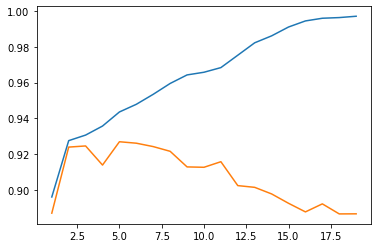

In [139]:
from sklearn.metrics import f1_score


plot_fitting_curve('max_depth', np.arange(1, 20), f1_score, X_train, X_test, y_train, y_test)

Видно, что на глубине больше трех наступает переобучение и качество на тестовой выборке начинает падать.

Далее попробуем перебрать минимальное число примеров в узле для разбиения.

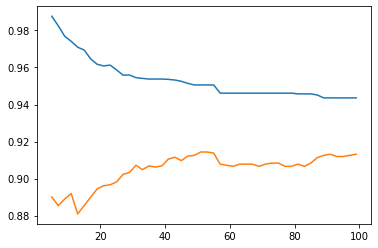

In [140]:
plot_fitting_curve('min_samples_split', np.arange(5, 100, 2), f1_score, X_train, X_test, y_train, y_test)

В случае с этим параметром видно, что его увеличение хорошо влияет на сходимость модели. В какой-то момент увеличение этого параметра перестает влиять на значение f1-меры на обучении и тесте.

Дальше попробуем перебрать параметр `max_features`, отвечающий за максимальное число признаков, используемых для разбиения.

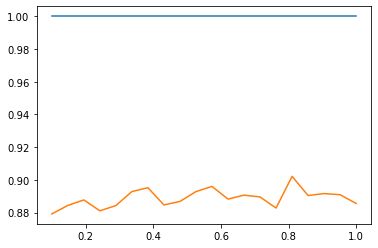

In [141]:
plot_fitting_curve('max_features', np.linspace(0.1, 1, 20), f1_score, X_train, X_test, y_train, y_test)

### Решающая граница

Наконец посмотрим, как выглядит решающая граница, которую строит дерево решений. Для этого возьмем датасет с ирисами и выберем из него два произвольных признака.

In [142]:
df = pd.DataFrame(data=iris_dataset.data, columns=iris_dataset.feature_names)
df['target'] = iris_dataset.target
df['target'] = df.target.apply(lambda v: iris_dataset.target_names[v])

print(df.columns)

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')


In [143]:
df.corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


Оставим длину чашелистника и ширину чашелистника

In [144]:
X = df.drop(columns=['target'])[['sepal length (cm)', 'sepal width (cm)']].rename(columns={'sepal length (cm)': 0, 'sepal width (cm)': 1})
y = df.target.map({'setosa': 0, 'versicolor': 1, 'virginica': 2})
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=42)

In [145]:
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap


def get_meshgrid(data, step=.05, border=.5,):
    x_min, x_max = data.iloc[:, 0].min() - border, data.iloc[:, 0].max() + border
    y_min, y_max = data.iloc[:, 1].min() - border, data.iloc[:, 1].max() + border
    
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def plot_decision_surface(estimator, train_data, train_labels, test_data, test_labels):
    estimator.fit(train_data, train_labels)
    
    plt.figure(figsize = (16, 6))
    light_colors = ListedColormap(['lightyellow','lightcoral','lightgreen'])
    colors = ListedColormap(['yellow', 'red', 'green'])
    
    #plot decision surface on the train data 
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(estimator.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
    plt.scatter(train_data.iloc[:, 0], train_data.iloc[:, 1], c=train_labels, s=40, cmap=colors)
    plt.title('Train data, accuracy={}'.format(accuracy_score(train_labels, estimator.predict(train_data))))
    
    #plot decision surface on the test data
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
    plt.scatter(test_data.iloc[:, 0], test_data.iloc[:, 1], c=test_labels, s=40, cmap=colors)
    plt.title('Test data, accuracy={}'.format(accuracy_score(test_labels, estimator.predict(test_data))))

C:\Users\misha\AppData\Local\Temp/ipykernel_440/1475892264.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
C:\Users\misha\AppData\Local\Temp/ipykernel_440/1475892264.py:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)


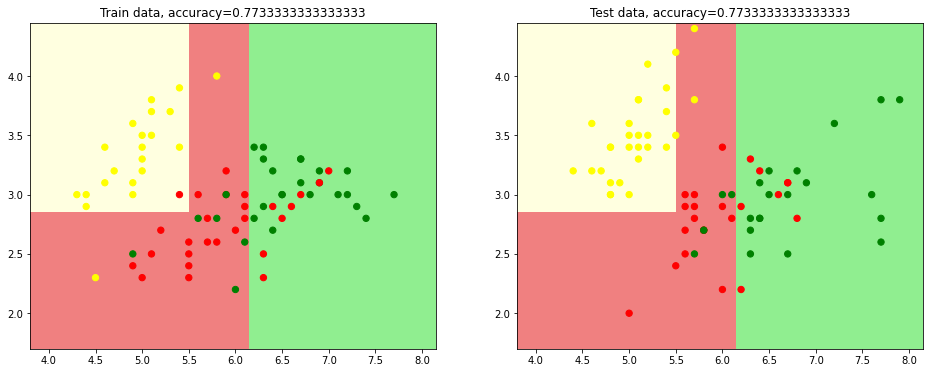

In [146]:
sklearn_tree = DecisionTreeClassifier(max_depth=2)

plot_decision_surface(sklearn_tree, X_train, y_train, X_test, y_test)

C:\Users\misha\AppData\Local\Temp/ipykernel_440/1475892264.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
C:\Users\misha\AppData\Local\Temp/ipykernel_440/1475892264.py:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)


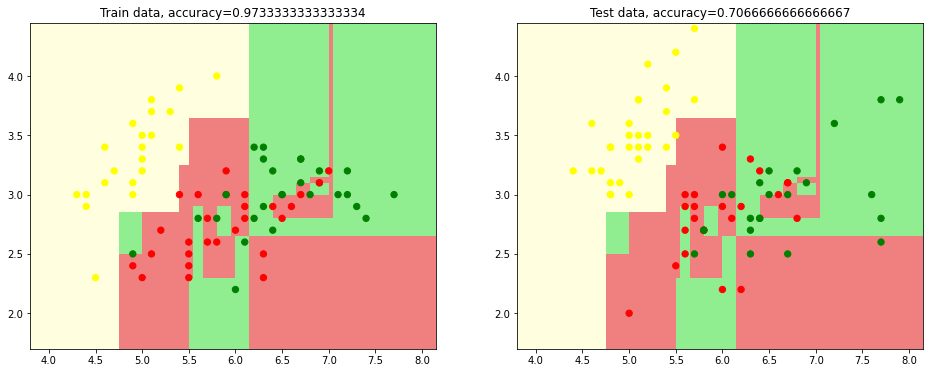

In [147]:
sklearn_tree = DecisionTreeClassifier(max_depth=100)

plot_decision_surface(sklearn_tree, X_train, y_train, X_test, y_test)

Если сравнить эти четыре картинки, то можно заметить, как возрастает сложность разделяющей границы в зависимости от глубины дерева. При этом обратите внимание, что все разделяющие границы проходят по прямой относительно оси. Это связано с тем, что разделяющее правило $X < x_0$ соответствует прямой, проходящей через $x_0$ перпендикулярно оси $X$.